In [1]:
!pip install pybbn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import relevant items
import pandas as pd
import numpy as np

import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

%matplotlib inline

In [3]:
df = pd.read_csv('X:\RA_AirQuality\combined_final_dataset.csv')

In [4]:
df.describe()

,TEMP,CO,NO,NO2,PM10,PM2.5,HUM,DIR,SPD,PRES,Month,Hour,TF_CNT
count,8421.000000,8421.000000,8419.000000,8417.000000,8421.000000,7273.000000,8421.000000,8417.000000,8417.000000,8421.000000,8760.000000,8760.000000,7104.000000
mean,9.358405,1.099120,19.336649,21.188987,10.081064,5.825896,54.352243,151.047809,1.119260,625.537706,6.526027,11.500000,4903.651605
std,13.526938,66.300765,34.868420,15.406607,12.486161,6.340252,22.910919,70.020545,0.836195,5.865070,3.448048,6.922582,2334.466740
min,-20.540000,-4.480000,-2.050000,1.300000,0.020000,0.010000,6.210000,0.900000,0.000000,562.450000,1.000000,0.000000,0.000000
25%,-2.180000,0.190000,1.310000,8.810000,2.630000,2.240000,35.120000,92.260000,0.550000,621.540000,4.000000,5.750000,2672.000000
50%,9.660000,0.300000,5.000000,17.600000,6.590000,3.850000,55.760000,148.440000,0.910000,625.000000,7.000000,11.500000,5468.000000
75%,20.630000,0.450000,20.625000,31.320000,12.850000,6.700000,70.200000,188.930000,1.440000,630.400000,10.000000,17.250000,6764.000000
max,39.180000,6084.470000,413.500000,203.700000,242.600000,69.400000,101.700000,359.000000,8.400000,635.800000,12.000000,23.000000,12407.000000


In [5]:
df=df[pd.isnull(df['PM2.5'])==False]

In [6]:
df=df.fillna(df.mean())

In [7]:
df.isnull().values.any()

False

In [8]:
# df = df.drop(columns=['PM10', 'hr_sin', 'hr_cos', 'month_sin','month_cos','TF_CNT_1', 'TF_CNT_2', 'TF_CNT_3', 'TF_CNT_4'])
# df = df.drop(columns=['Hour','Month'])
# df = df.drop(df.columns[0], axis=1)

In [9]:
df['PM2.5>10']=df['PM2.5'].apply(lambda x: 'Yes' if x>10 else 'No')

In [10]:
df['TF_CNT>4000']=df['TF_CNT'].apply(lambda x: 'Yes' if x>4000 else 'No')

In [11]:
df['SPD>1.5']=df['SPD'].apply(lambda x: 'Yes' if x>1.5 else 'No')

In [12]:
df['TEMP>15']=df['TEMP'].apply(lambda x: 'Yes' if x>15 else 'No')

In [13]:
df.head()

,DateTime,TEMP,CO,NO,NO2,PM10,PM2.5,HUM,DIR,SPD,PRES,Month,Hour,TF_CNT,PM2.5>10,TF_CNT>4000,SPD>1.5,TEMP>15
0,2019-01-01 00:00:00,-13.26,0.28,1.66,7.00,8.62,6.30,80.04,189.90,2.65,625.00,1,0,2042.0,No,No,Yes,No
1,2019-01-01 01:00:00,-14.22,0.27,0.66,6.00,8.71,4.41,75.21,282.43,2.70,625.24,1,1,1949.0,No,No,Yes,No
2,2019-01-01 02:00:00,-14.30,0.29,0.63,7.31,6.82,5.24,79.09,310.47,2.26,630.04,1,2,1527.0,No,No,Yes,No
3,2019-01-01 03:00:00,-14.44,0.29,0.56,6.42,9.10,6.56,79.54,295.01,2.18,630.40,1,3,1403.0,No,No,Yes,No
4,2019-01-01 04:00:00,-14.82,0.29,0.72,8.13,5.94,4.70,79.86,298.92,1.55,630.40,1,4,1793.0,No,No,Yes,No


In [14]:
df['PM2.5>10'].value_counts().sort_index()

No     6250
Yes    1023
Name: PM2.5>10, dtype: int64

In [15]:
df['TF_CNT>4000'].value_counts().sort_index()

No     1849
Yes    5424
Name: TF_CNT>4000, dtype: int64

In [16]:
df['SPD>1.5'].value_counts().sort_index()

No     5474
Yes    1799
Name: SPD>1.5, dtype: int64

In [17]:
df['TEMP>15'].value_counts().sort_index()

No     4032
Yes    3241
Name: TEMP>15, dtype: int64

In [18]:
# This function helps to calculate probabily distribution, which goes into BBN (note, can handle upto 2 parents)
def probs(data, child, parent1=None, parent2=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Work out the bands present in the parent variable
                bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            else:    
                # Work out the bands present in the parent variable
                bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).sort_index().tolist()
                        prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob

In [34]:
# Create nodes by using our earlier function to automatically calculate probabilities
tfcnt_gt_4000 = BbnNode(Variable(0, 'tfcnt_gt_4000', ['Yes', 'No']), probs(df, child='TF_CNT>4000'))
# spd_gt_1dot5 = BbnNode(Variable(1, 'spd_gt_1dot5', ['Yes', 'No']), probs(df, child='SPD>1.5'))
temp_gt_15 = BbnNode(Variable(2, 'temp_gt_15', ['Yes', 'No']), probs(df, child='TEMP>15'))
pm25_gt_10 = BbnNode(Variable(3, 'pm25_gt_10', ['Yes', 'No']), probs(df, child='PM2.5>10', parent1='TF_CNT>4000', parent2='TEMP>15'))

In [35]:
# Create Network
bbn = Bbn() \
    .add_node(tfcnt_gt_4000) \
    .add_node(temp_gt_15) \
    .add_node(pm25_gt_10) \
    .add_edge(Edge(tfcnt_gt_4000, pm25_gt_10, EdgeType.DIRECTED)) \
    .add_edge(Edge(temp_gt_15, pm25_gt_10, EdgeType.DIRECTED)) \

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

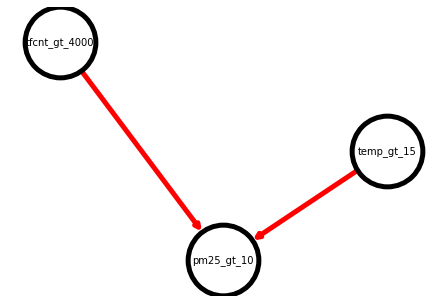

In [36]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 5000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [37]:
#function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 2|temp_gt_15|Yes,No
Values:
2=Yes|0.55438
2=No|0.44562
----------------
Node: 3|pm25_gt_10|Yes,No
Values:
3=Yes|0.86400
3=No|0.13600
----------------
Node: 0|tfcnt_gt_4000|Yes,No
Values:
0=Yes|0.25423
0=No|0.74577
----------------


In [39]:
# To add evidence to calculate probability distribution
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

evidence(ev=None, nod='tfcnt_gt_4000', cat='Yes', val=1.0)

# Print marginal probabilities
print_probs()

Node: 2|temp_gt_15|Yes,No
Values:
2=Yes|0.55438
2=No|0.44562
----------------
Node: 3|pm25_gt_10|Yes,No
Values:
3=Yes|0.92905
3=No|0.07095
----------------
Node: 0|tfcnt_gt_4000|Yes,No
Values:
0=Yes|1.00000
0=No|0.00000
----------------


In [40]:
evidence(ev=None, nod='temp_gt_15', cat='No', val=1.0)
print_probs()

Node: 2|temp_gt_15|Yes,No
Values:
2=Yes|0.00000
2=No|1.00000
----------------
Node: 3|pm25_gt_10|Yes,No
Values:
3=Yes|0.95829
3=No|0.04171
----------------
Node: 0|tfcnt_gt_4000|Yes,No
Values:
0=Yes|1.00000
0=No|0.00000
----------------
